<a href="https://colab.research.google.com/github/crimama/DL_study/blob/main/unet_practice_load.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 다운로드

In [ ]:
!pip install tensorflow-datasets

In [2]:
!pip install tfds-nightly

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds


ds = tfds.load('lost_and_found', split='train', batch_size=200)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1036 [00:00<?, ? examples/s]

Shuffling lost_and_found-train.tfrecord...:   0%|          | 0/1036 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/1203 [00:00<?, ? examples/s]

Shuffling lost_and_found-test.tfrecord...:   0%|          | 0/1203 [00:00<?, ? examples/s]

Dataset lost_and_found downloaded and prepared to /root/tensorflow_datasets/lost_and_found/semantic_segmentation/1.0.0. Subsequent calls will reuse this data.


# 데이터 로드 

In [4]:
dataset = next(iter(ds))

In [5]:
print(dataset.keys())

dict_keys(['image_id', 'image_left', 'segmentation_label'])


In [72]:
images = dataset['image_left'].numpy()
labels = dataset['segmentation_label'].numpy()

In [73]:
print(images.shape)
print(labels.shape)

(200, 1024, 2048, 3)
(200, 1024, 2048, 1)


In [74]:
print(np.max(labels), np.min(labels))

38 0


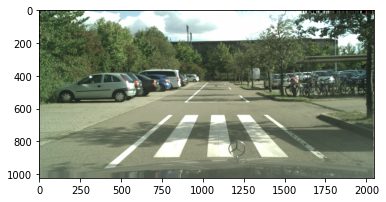

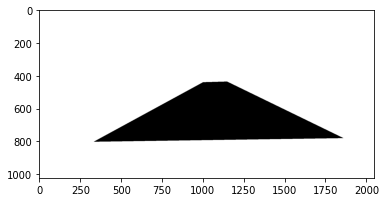

In [103]:
#로드 한 데이터 확인 
import matplotlib.pyplot as plt
plt.imshow(images[0])
plt.show()

plt.imshow(labels[0].squeeze(),'binary')
plt.show()

# 전처리 

## label 전처리

- 배경이 아닌 것(>0)은 전부 전경(1)으로 처리한다.
- label을 명확히 하기 위함 

In [77]:
labels[labels>0]=1

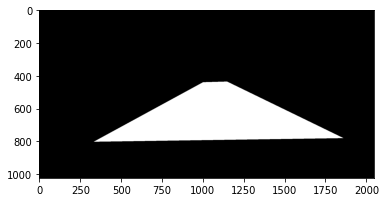

In [78]:
plt.imshow(labels[0].squeeze(),'gray')

## 리사이즈

In [79]:
print(images.shape, labels.shape)

(200, 1024, 2048, 3) (200, 1024, 2048, 1)


In [80]:
import cv2 
raw_x = []
for i in range(len(images)):
  temp = cv2.resize(images[i],dsize = (256,256))
  raw_x.append(temp)
raw_x = np.array(raw_x)

raw_y = []
for i in range(len(images)):
  temp = cv2.resize(labels[i],dsize = (256,256))
  raw_y.append(temp)
raw_y = np.array(raw_y)

In [81]:
raw_y = raw_y.reshape(200,256,256,1)

In [82]:
print(raw_x.shape, raw_y.shape)

(200, 256, 256, 3) (200, 256, 256, 1)


## 정규화 

In [122]:
x = (raw_x/255).astype(np.float)
y = (raw_y/255).astype(np.int)

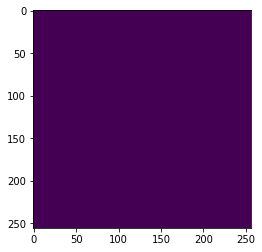

In [124]:
plt.imshow(y[0].squeeze())

## 데이터 분할 

In [125]:
from sklearn.model_selection import train_test_split
train_x,test_x, train_y,test_y = train_test_split(x,y, random_state=42)

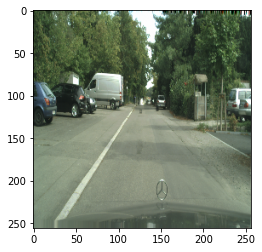

In [126]:
plt.imshow(train_x[0])

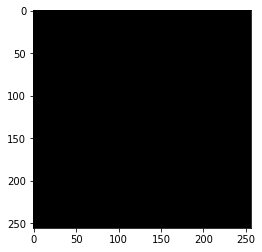

In [127]:
plt.imshow(train_y[0].squeeze(),'gray')

# 모델링

## 모듈 임포트 

In [95]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras import backend as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

def unet(input_size=(256,256,3)): #train_x, test_x 는 256,256,3의 shape을 가져야 함 
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    
    up = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5)
    up6 = concatenate([up, conv4], axis=3) # <---------- Conv4 를 넣음 
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    
    up = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up, conv3], axis=3) # <------------ Conv 3를 넣음 
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    
    up = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7)
    up8 = concatenate([up, conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    
    up = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8) #<--- maxpooling과 반대의 역할을 함, 앞선 conv1과 반대의 작용을 하기 때문 
    up9 = concatenate([up, conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9) #<-------- 1장으로 만듬 

    return Model(inputs=[inputs], outputs=[conv10])

## 모델 컴파일, 학습

In [115]:
model = unet()

model.compile(optimizer = 'adam', loss = 'mse', metrics = ['accuracy'])

hist = model.fit(train_x,train_y, batch_size = 32, epochs = 20, verbose=1, validation_split = 0.2)

Epoch 1/20
4/4 [==============================] - 5s 493ms/step - loss: 0.2660 - accuracy: 0.5148 - val_loss: 0.2379 - val_accuracy: 0.7085
Epoch 2/20
4/4 [==============================] - 1s 318ms/step - loss: 0.1960 - accuracy: 0.6832 - val_loss: 0.2013 - val_accuracy: 0.8184
Epoch 3/20
4/4 [==============================] - 1s 319ms/step - loss: 0.1582 - accuracy: 0.7200 - val_loss: 0.1774 - val_accuracy: 0.8116
Epoch 4/20
4/4 [==============================] - 1s 317ms/step - loss: 0.1354 - accuracy: 0.7484 - val_loss: 0.2657 - val_accuracy: 0.6663
Epoch 5/20
4/4 [==============================] - 1s 319ms/step - loss: 0.1188 - accuracy: 0.7662 - val_loss: 0.3263 - val_accuracy: 0.5669
Epoch 6/20
4/4 [==============================] - 1s 320ms/step - loss: 0.1108 - accuracy: 0.7657 - val_loss: 0.3543 - val_accuracy: 0.5760
Epoch 7/20
4/4 [==============================] - 1s 317ms/step - loss: 0.1026 - accuracy: 0.7750 - val_loss: 0.5350 - val_accuracy: 0.4382
Epoch 8/20
4/4 [====

## 모델 검증 

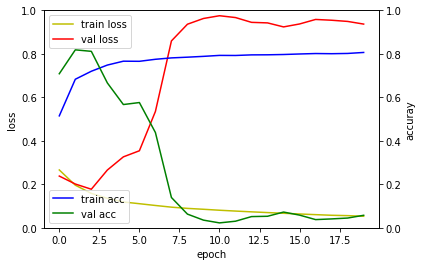

In [116]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 1.0])

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylim([0.0, 1.0])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

## 예측 

In [121]:
y_.shape

(50, 256, 256, 1)

In [119]:
y_ = model.predict(test_x)
predicted = y_

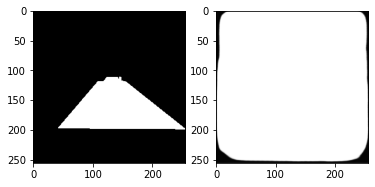

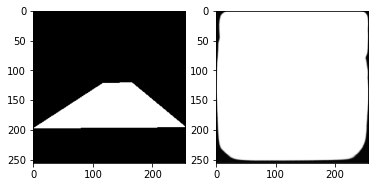

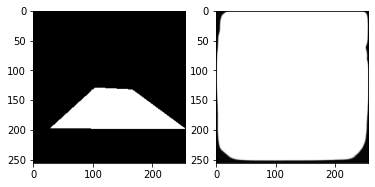

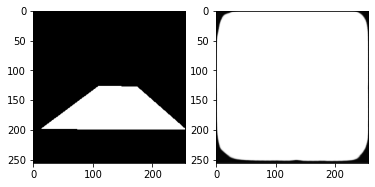

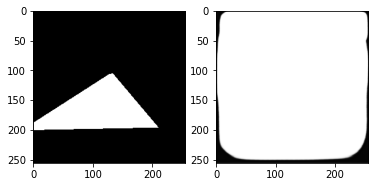

In [120]:
for i in range(5):
  plt.subplot(1,2,1)
  plt.imshow(train_y[i].squeeze(),'gray')
  plt.subplot(1,2,2)
  plt.imshow(y_[i].squeeze(),'gray')
  plt.show()